In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import normalize, minmax_scale
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from scipy.stats import skew
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split


### Load data provided by PJM 
From: https://www.pjm.com/-/media/library/reports-notices/special-reports/2018/2018-emissions-report.ashx?la=en 

In [14]:
calc = pd.read_csv("pjm-mefs.csv")

### Updated Regression with More Data

In [15]:
# Label the df with the year, month, hour, and season 
def label_year_month(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    return df

In [16]:
# Load ISO/RTO data, focus on PJM 
isorto_data1 = pd.read_csv("../data/formatted_data/cems_isorto.csv", index_col=0, parse_dates=[0])

isorto_data1 = isorto_data1.loc[isorto_data1['isorto'] == 'PJM']
isorto_data1 = label_year_month(isorto_data1)

In [17]:
# Group by year and month
data = isorto_data1.copy()
data = data.groupby(['year', 'month']).sum()
data = data.reset_index()

# Get MEF from PJM then find the MEF from the last hour
df = pd.merge(data, calc, how='left', on=['year', 'month'])
df['prev_co2_mef'] = df.mef.shift(1)
df = df.dropna()
df = df.drop_duplicates(subset=['year', 'month'], keep='first')
df = df[['year', 'month', 'co2_kg', 'so2_kg', 'nox_kg', 'pm25_kg', 'gload_mwh', 'prev_co2_mef', 'mef']]
df['gload_mwh'] = df['gload_mwh'].abs()

df.head()

,year,month,co2_kg,so2_kg,nox_kg,pm25_kg,gload_mwh,prev_co2_mef,mef
97,2014,2,3.561988e+10,8.398652e+07,3.472216e+07,5.023754e+06,46326701.94,1194.0,1212.0
98,2014,3,3.629593e+10,8.307979e+07,3.421347e+07,5.014618e+06,47451238.04,1212.0,1187.0
99,2014,4,2.838108e+10,6.188533e+07,2.648181e+07,3.863330e+06,36436451.24,1187.0,1088.0
100,2014,5,2.771748e+10,5.290305e+07,2.433106e+07,3.680962e+06,37329309.76,1088.0,1049.0
101,2014,6,3.405126e+10,6.677364e+07,2.805294e+07,4.467686e+06,44531938.01,1049.0,1116.0


In [18]:
# sin / cosine correction for month 
df['cos_month'] = np.cos((df.month)*(2*np.pi/12))
df['sin_month'] = np.sin((df.month)*(2*np.pi/12))

In [41]:
# Start with CO2 Calculations
x = df[['year', 'sin_month', 'cos_month', 'co2_kg', 'so2_kg', 'nox_kg', 'pm25_kg', 'gload_mwh', 'prev_co2_mef']]
y = df[['mef']]

### Visualize Data

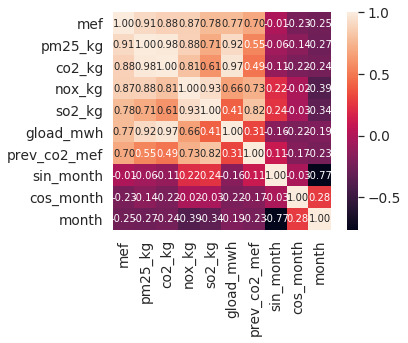

In [13]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'mef')['mef'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

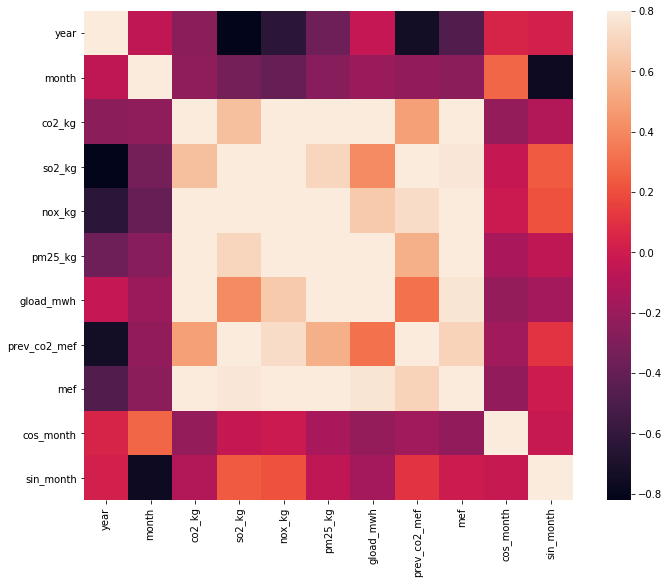

In [10]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

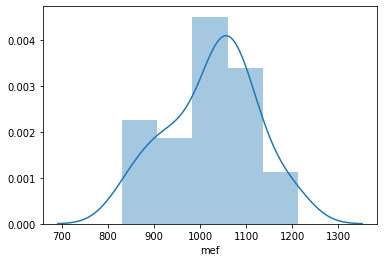

In [28]:
sns.distplot(df['mef'])

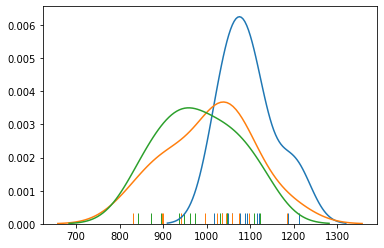

In [29]:
df_2012 = df.loc[df['year'] == 2014]
df_2013 = df.loc[df['year'] == 2015]
df_2014 = df.loc[df['year'] == 2016]

sns.distplot(df_2012[['mef']], hist=False, rug=True)
sns.distplot(df_2013[['mef']], hist=False, rug=True)
sns.distplot(df_2014[['mef']], hist=False, rug=True)

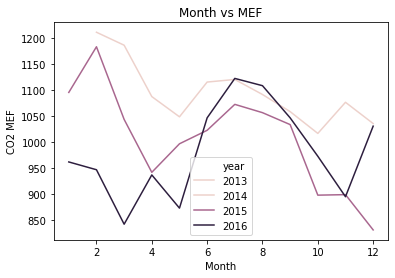

In [21]:
sns.lineplot(x="month", y="mef", hue="year", data=df)

plt.title("Month vs MEF")
plt.xlabel('Month')
plt.ylabel('CO2 MEF')


plt.show()

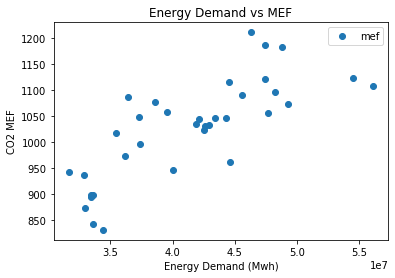

In [22]:
df.plot(x='gload_mwh', y='mef', style='o')  
plt.title('Energy Demand vs MEF')  
plt.xlabel('Energy Demand (Mwh)')
plt.ylabel('CO2 MEF')

plt.show()

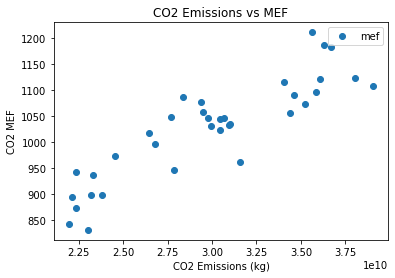

In [25]:
df.plot(x='co2_kg', y='mef', style='o')  
plt.title('CO2 Emissions vs MEF')  
plt.xlabel('CO2 Emissions (kg)')
plt.ylabel('CO2 MEF')

plt.show()

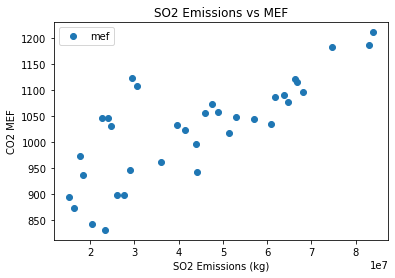

In [26]:
df.plot(x='so2_kg', y='mef', style='o')  
plt.title('SO2 Emissions vs MEF')  
plt.xlabel('SO2 Emissions (kg)')
plt.ylabel('CO2 MEF')

plt.show()

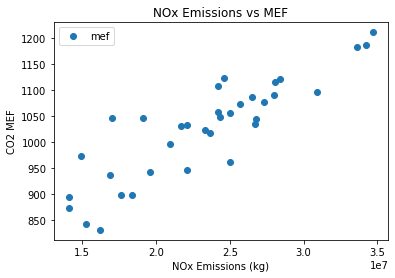

In [27]:
df.plot(x='nox_kg', y='mef', style='o')  
plt.title('NOx Emissions vs MEF')  
plt.xlabel('NOx Emissions (kg)')
plt.ylabel('CO2 MEF')
m
plt.show()

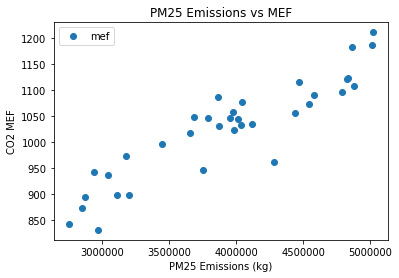

In [75]:
df.plot(x='pm25_kg', y='mef', style='o')  
plt.title('PM25 Emissions vs MEF')  
plt.xlabel('PM25 Emissions (kg)')
plt.ylabel('CO2 MEF')

plt.show()

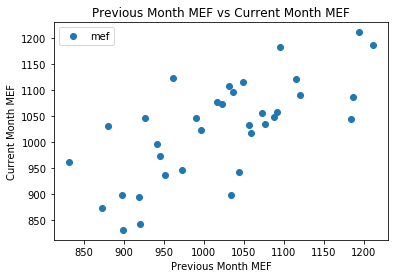

In [77]:
df.plot(x='prev_co2_mef', y='mef', style='o')  
plt.title('Previous Month MEF vs Current Month MEF')  
plt.xlabel('Previous Month MEF')
plt.ylabel('Current Month MEF')

plt.show()

### Implement Linear Regression

In [42]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 100) 
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [22]:
# Make predictions using the testing set
results = pd.DataFrame(index = x.index)
results['mef_predicted'] = lr.predict(x)
results['mef_actual'] = y['mef']

results.index = range(35)

In [49]:
# Make predictions using the testing set
results = pd.DataFrame(index = x.index)
results['mef_predicted'] = lr.predict(x)
results['mef_actual'] = y['mef']

results.index = range(35)

# Calculate error: sum of (y - y(hat)) / y(hat)^2 
temp = pd.DataFrame()
temp['diff'] = abs(results['mef_actual'] - results['mef_predicted'])
temp['error'] = temp['diff'] / (results['mef_actual'])
print("Test and training error: " + str(temp['error'].mean()))

# Test data 
test = pd.DataFrame(index = X_test.index)
test['mef_predicted'] = lr.predict(X_test)
test['mef_actual'] = y_test['mef']
test['diff'] = abs(test['mef_actual'] - test['mef_predicted'])
test['error'] = test['diff'] / (test['mef_actual'])
print("Test error: " + str(test['error'].mean()))

# Training data 
train = pd.DataFrame(index = X_train.index)
train['mef_predicted'] = lr.predict(X_train)
train['mef_actual'] = y_train['mef']
train['diff'] = abs(train['mef_actual'] - train['mef_predicted'])
train['error'] = train['diff'] / (train['mef_actual'])
print("Test error: " + str(train['error'].mean()))

Test and training error: 0.023880090771904307
Test error: 0.04342748854581303
Test error: 0.018993241328427134


In [26]:
lr.score(x, y)

0.8903780388204273

### Compare with univariate regression model
Results of this paper: https://pubs.acs.org/doi/10.1021/acs.est.8b06586

In [53]:
df_compare = pd.read_csv("mef-regression.csv", index_col=0)
df_compare = df_compare.loc[df_compare['pollutant'] == 'co2']

df_compare = df_compare[['year', 'month', 'factor']]
df_compare = df_compare[df_compare['year'].isin(['2014', '2015', '2016'])]

df_compare.columns = ['year', 'month', 'mef_univariate']
df_compare.index = range(35)

In [54]:
df_compare = df_compare.join(results)
df_compare

,year,month,mef_univariate,mef_predicted,mef_actual
0,2014,2,600.735353,1208.155066,1212.0
1,2014,3,653.488770,1213.541618,1187.0
2,2014,4,674.639737,1087.191727,1088.0
3,2014,5,671.333305,1020.153234,1049.0
4,2014,6,686.015935,1124.557737,1116.0
5,2014,7,689.249095,1189.320987,1121.0
6,2014,8,708.448409,1147.709146,1092.0
7,2014,9,696.836722,1048.409134,1059.0
8,2014,10,703.063725,1008.602689,1017.0
9,2014,11,672.504285,1041.709374,1077.0


In [55]:
df_graph = df_compare.melt(id_vars=["year", "month"], 
        var_name="Type", 
        value_name="mef")

df_graph['date'] = df_graph["year"].astype(str) + "-" + df_graph["month"].astype(str)
df_graph['date'] = pd.to_datetime(df_graph['date'])

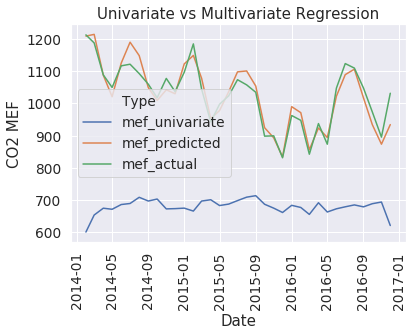

In [56]:
sns.lineplot(x='date', y="mef", hue="Type", data=df_graph)

plt.title("Univariate vs Multivariate Regression")
plt.xlabel('Date')
plt.ylabel('CO2 MEF')
_=plt.xticks(rotation=90)  
plt.show()

In [58]:
df_compare

,year,month,mef_univariate,mef_predicted,mef_actual
0,2014,2,600.735353,1208.155066,1212.0
1,2014,3,653.488770,1213.541618,1187.0
2,2014,4,674.639737,1087.191727,1088.0
3,2014,5,671.333305,1020.153234,1049.0
4,2014,6,686.015935,1124.557737,1116.0
5,2014,7,689.249095,1189.320987,1121.0
6,2014,8,708.448409,1147.709146,1092.0
7,2014,9,696.836722,1048.409134,1059.0
8,2014,10,703.063725,1008.602689,1017.0
9,2014,11,672.504285,1041.709374,1077.0


In [65]:
# Error from the paper compared to the real value 
temp = pd.DataFrame()

temp['diff'] = abs(df_compare['mef_actual'] - df_compare['mef_univariate'])
temp['error'] = temp['diff'] / (df_compare['mef_actual'])
temp.error.mean()

0.3320968304487124

In [66]:
temp


,diff,error
0,611.264647,0.504344
1,533.511230,0.449462
2,413.360263,0.379927
3,377.666695,0.360025
4,429.984065,0.385290
5,431.750905,0.385148
6,383.551591,0.351238
7,362.163278,0.341986
8,313.936275,0.308689
9,404.495715,0.375576


### Lasso

In [30]:
# Normalize x and y-train
X_train = (X_train-X_train.min())/(X_train.max()-X_train.min())

y_train = (y_train-y_train.min())/(y_train.max()-y_train.min())
y_train.head()

,mef
138,0.372703
126,0.278215
103,0.685039
106,0.645669
116,0.532808


In [31]:
from sklearn.metrics import make_scorer, mean_squared_error

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

    # scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

In [43]:
from sklearn.model_selection import GridSearchCV

# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score:  0.6437177987544017
Best Params:  {'alpha': 10}


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.5s finished


In [44]:
# final one
lasso = Lasso(alpha=10, max_iter=10e5)
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)

print("training score:", train_score)
print("test score: ", test_score)
print("number of features used:", coeff_used)

training score: 0.9137072028440886
test score:  0.7585698779189871
number of features used: 6


In [51]:
lasso.score(x,y)

0.8919084684804819

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

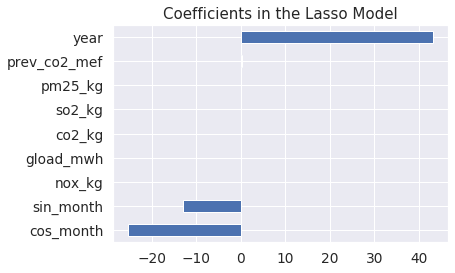

In [35]:
imp_coef = pd.concat([coef.sort_values().head(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [45]:
# Make predictions using the testing set
results_lasso = pd.DataFrame(index = x.index)
results_lasso['mef_predicted'] = lasso.predict(x)
results_lasso['mef_actual'] = y['mef']

In [50]:
# Calculate error: sum of (y - y(hat)) / y(hat) 
temp = pd.DataFrame()
temp['diff'] = abs(results_lasso['mef_actual'] - results_lasso['mef_predicted'])
temp['error'] = temp['diff'] / (results_lasso['mef_actual'])
print("Test and training error: " + str(temp['error'].mean()))

# Test data 
test = pd.DataFrame(index = X_test.index)
test['mef_predicted'] = lr.predict(X_test)
test['mef_actual'] = y_test['mef']
test['diff'] = abs(test['mef_actual'] - test['mef_predicted'])
test['error'] = test['diff'] / (test['mef_actual'])
print("Test error: " + str(test['error'].mean()))

# Training data 
train = pd.DataFrame(index = X_train.index)
train['mef_predicted'] = lr.predict(X_train)
train['mef_actual'] = y_train['mef']
train['diff'] = abs(train['mef_actual'] - train['mef_predicted'])
train['error'] = train['diff'] / (train['mef_actual'])
print("Training error: " + str(train['error'].mean()))

Test and training error: 0.025250155136706864
Test error: 0.04342748854581303
Training error: 0.018993241328427134
